In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [333]:
import tensorflow as tf
import pugna.layers
import pugna.activations
import pugna.models.mscalednn

In [373]:
from sklearn.model_selection import train_test_split

In [66]:
def make_training_data(npts=100, percentage=0.25):
    x = np.linspace(-1, 1, npts)
    y = np.sin(2*np.pi*0.3*x)
    
    # select the index corresponding the the percentage along the x
    index = int(percentage * npts)
    
    delta_func = signal.unit_impulse(npts, index)
    
    x = x[:, np.newaxis]
    y = y+delta_func
    y = y[:, np.newaxis]
    
    return x, y

In [596]:
x, y = make_training_data(npts=2000)
x, xval, y, yval = train_test_split(x, y, test_size=0.33, random_state=2)

In [597]:
x.shape

(1340, 1)

In [598]:
y.shape

(1340, 1)

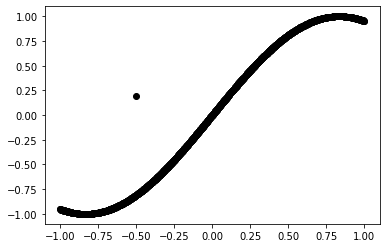

In [599]:
plt.plot(x, y, 'ko')
# plt.plot(xval, yval, 'go')

# setup model

In [600]:
def plot_history(history, labels=None):
    plt.figure()
    for i, h in enumerate(history):
        loss = h.history["loss"]
        if labels:
            plt.plot(range(len(loss)), loss, label=labels[i])
        else:
            plt.plot(range(len(loss)), loss)
    plt.yscale("log")
    plt.title('train')    
    if labels:
        plt.legend(bbox_to_anchor=(1.05, 1))
    
    if "val_loss"  in history[0].history.keys():
        plt.figure()
        for h in history:
            loss = h.history["val_loss"]
            plt.plot(range(len(loss)), loss, ls='--')
        plt.yscale("log")
        plt.title('validation')

In [601]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [602]:
def build_and_fit_model(
    x,
    y,
    verbose=False,
    batch_size=None,
    nscales=1,
    epochs=1000,
    units=300,
    lr=0.001,
    activation='srelu',
    validation_data=None,
    scale_name='linear',
    use_mscale=False
):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
    if use_mscale:
        model.add(pugna.layers.Mscale(units, nscales, scale_name=scale_name))
    else:
        model.add(tf.keras.layers.Dense(units))
    if activation == 'srelu':
        model.add(tf.keras.layers.Activation(pugna.activations.sReLU))
    elif activation == 's2relu':
        model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    elif activation == 'relu':
        model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
    elif activation == 'tanh':
        model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))

        
    model.add(pugna.layers.Mscale(units, nscales, scale_name=scale_name))
    model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
        
#     model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # optimizer = tf.keras.optimizers.Adam(lr)
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
    #optimizer = tf.keras.optimizers.Nadam(lr)
    # optimizer = tf.keras.optimizers.SGD(lr)
    model.compile(loss="mse", optimizer=optimizer)

    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)

    return history, model

In [603]:
 def lowest_loss(historys, models):
    losses = [history.history['loss'][-1] for history in historys]
    idx = np.argmin(losses)
    print(f"idx: {idx} had the lowest loss")
    return historys[idx], models[idx]

# standard dense layer

In [604]:
%%time
ntries = 10
epochs = 1000
batch_size = x.shape[0]
history1s = []
model1s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    
    
#     model = pugna.models.mscalednn.build_model(1, 1, 2, [300], [1], ['relu'], [0], [False], ['linear'])
    model = pugna.models.mscalednn.build_model(1, 1, 2, [300, 300], [1,1], ['relu', 'relu'], [0, 0], [False, False], ['linear', 'linear'])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    callbacks = []
    learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(0.001, 10)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

    history = model.fit(
        x,
        y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=False,
        callbacks=callbacks,
        validation_data=(xval, yval)
    )

    history1s.append(history)
    model1s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 7min 10s, sys: 37.4 s, total: 7min 48s
Wall time: 4min 9s


In [605]:
history1, model1 = lowest_loss(history1s, model1s) 

idx: 3 had the lowest loss


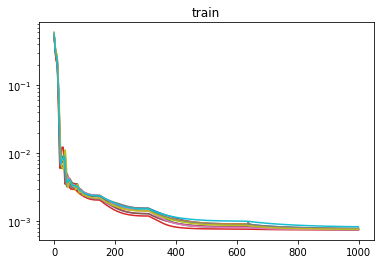

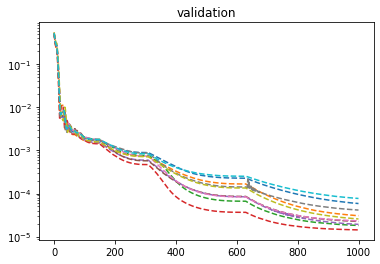

In [606]:
plot_history(history1s)

In [607]:
yhat1 = model1.predict(x) 

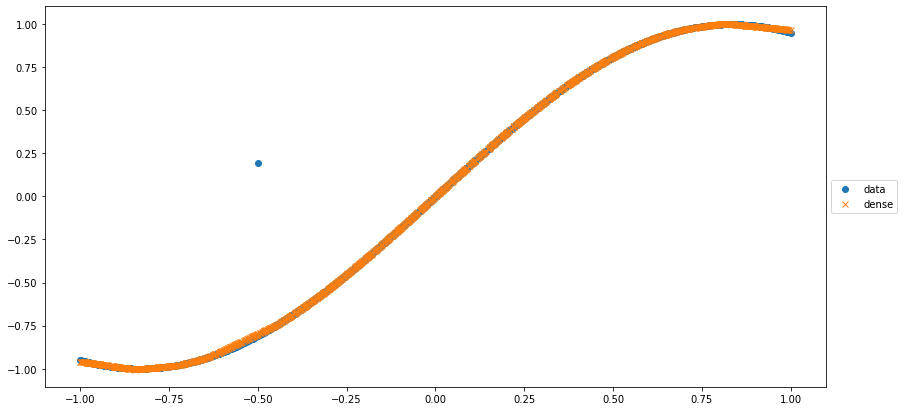

In [608]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, 'o', label='data')
plt.plot(x, yhat1, 'x', label='dense')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# mscale

In [624]:
%%time
ntries = 10
epochs = 1000
batch_size = x.shape[0]
history2s = []
model2s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    
    
#     model = pugna.models.mscalednn.build_model(1, 1, 2, [300, 300], [50,1], ['s2relu', 's2relu'], [0, 0], [False, False], ['linear', 'linear'])
    model = pugna.models.mscalednn.build_model(1, 1, 2, [600, 300], [9,1], ['s2relu', 's2relu'], [0, 0], [False, False], ['base2', 'linear'])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    callbacks = []
    learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(0.001, 10)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

    history = model.fit(
        x,
        y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=False,
        callbacks=callbacks,
        validation_data=(xval, yval)
    )

    history2s.append(history)
    model2s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 15min 18s, sys: 8min 5s, total: 23min 24s
Wall time: 7min 15s


In [625]:
history2, model2 = lowest_loss(history2s, model2s)

idx: 1 had the lowest loss


In [626]:
# model2.layers[0].K.numpy() 

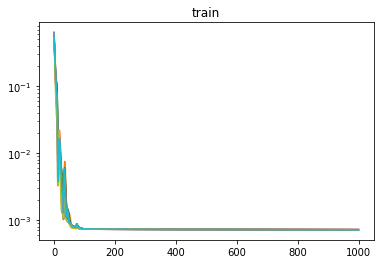

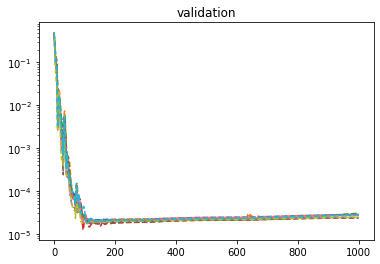

In [627]:
plot_history(history2s) 

In [628]:
yhat2 = model2.predict(x) 

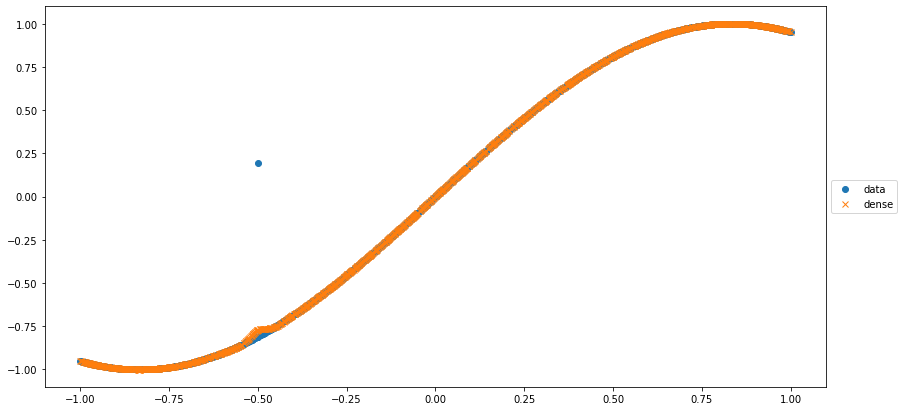

In [629]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, 'o', label='data')
plt.plot(x, yhat2, 'x', label='dense')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# compare

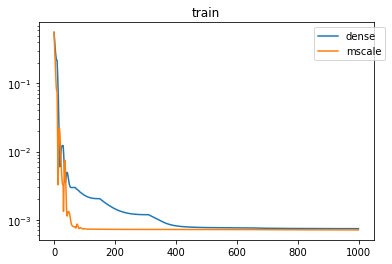

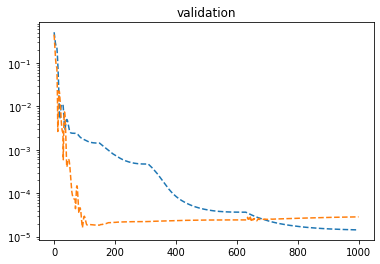

In [630]:
plot_history([history1, history2], labels=['dense', 'mscale']) 

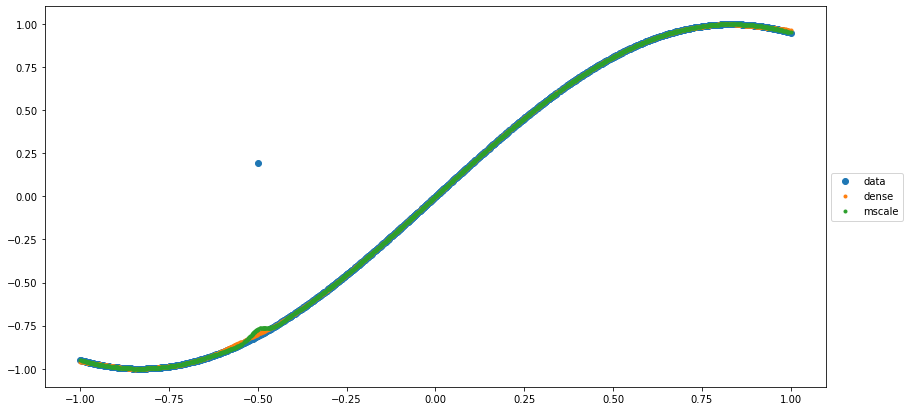

In [631]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, 'o', label='data')
plt.plot(x, yhat1, 'o', label='dense', markersize=3)
plt.plot(x, yhat2, 'o', label='mscale', markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [632]:
yres1 = tf.keras.losses.mse(y, yhat1)
yres2 = tf.keras.losses.mse(y, yhat2)

Text(0.5, 1.0, 'MSE residuals')

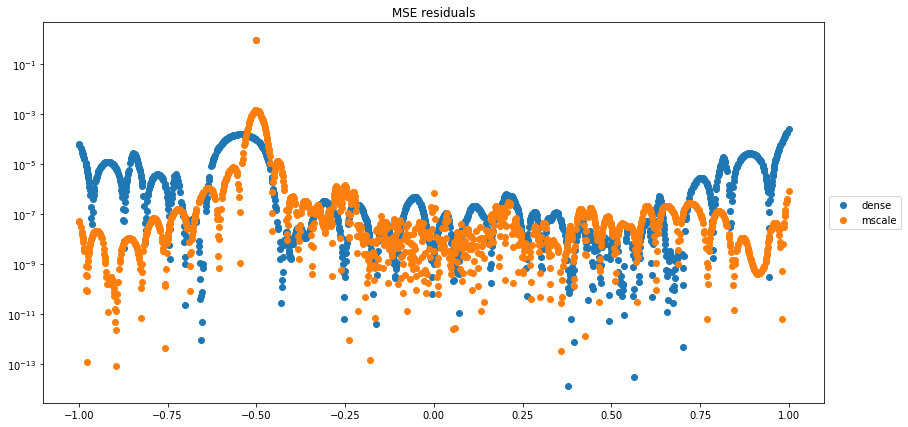

In [633]:
plt.figure(figsize=(14, 7))
plt.plot(x, yres1, 'o', label='dense')
plt.plot(x, yres2, 'o', label='mscale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("MSE residuals")

# compare validation

In [619]:
yvalhat1 = model1.predict(xval) 

In [620]:
yvalhat2 = model2.predict(xval) 

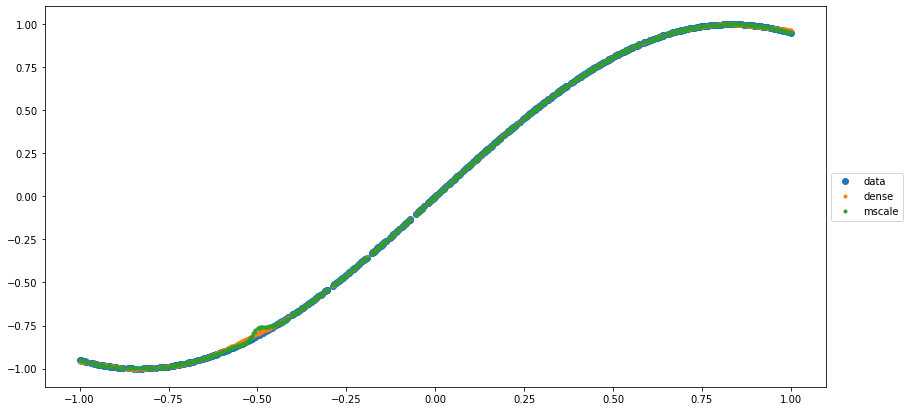

In [621]:
plt.figure(figsize=(14, 7))
plt.plot(xval, yval, 'o', label='data')
plt.plot(xval, yvalhat1, 'o', label='dense', markersize=3)
plt.plot(xval, yvalhat2, 'o', label='mscale', markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [622]:
yvalres1 = tf.keras.losses.mse(yval, yvalhat1)
yvalres2 = tf.keras.losses.mse(yval, yvalhat2)

Text(0.5, 1.0, 'MSE residuals')

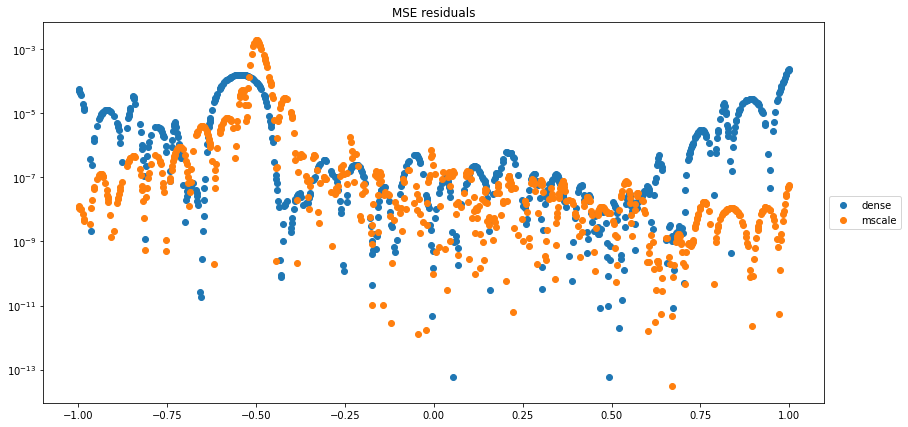

In [623]:
plt.figure(figsize=(14, 7))
plt.plot(xval, yvalres1, 'o', label='dense')
plt.plot(xval, yvalres2, 'o', label='mscale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("MSE residuals")